In [1]:
import pandas as pd
from rdkit import Chem, rdBase
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdRGroupDecomposition as rdRGD

from rgroupinterm.rgroupenumeration import EnumRGroups

rdBase.DisableLog('rdApp.*')

In [2]:
smiles = [
    'CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc(O)cc1)N2',
    '[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccccc1'
]
mols = [Chem.MolFromSmiles(x) for x in smiles]

generator = EnumRGroups()

df_interm, core_new = generator.generate_intermediates(mols)
intermediates = df_interm['Intermediate'].tolist()

print(len(intermediates))

6


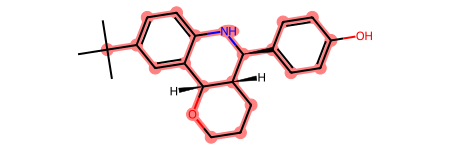

In [3]:
mols[0]

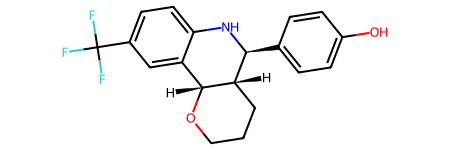

In [4]:
intermediates[0]

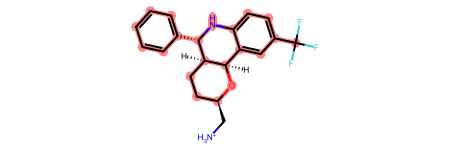

In [5]:
mols[1]

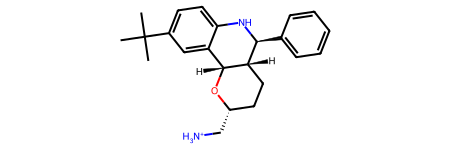

In [6]:
intermediates[-1]

# Template
From https://www.valencekjell.com/posts/2021-10-15-chiral-templating/index.html

In [7]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
IPythonConsole.drawOptions.addStereoAnnotation = True
IPythonConsole.ipython_useSVG=True 

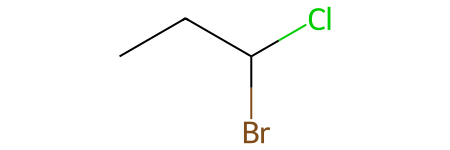

In [8]:
smiles = "C(Cl)(Br)CC"
mol = Chem.MolFromSmiles(smiles)
display(mol)

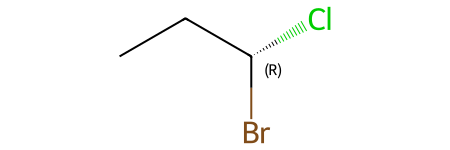

In [9]:
smiles_ref = "Br[C@@H](Cl)CC"
mol_ref = Chem.MolFromSmiles(smiles_ref)
display(mol_ref)

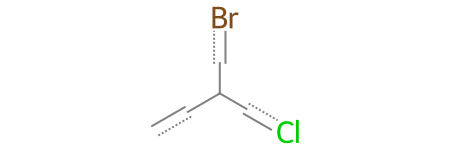

In [10]:
smarts = "[C][C@@H]([Br])[Cl]"
pattern = Chem.MolFromSmarts(smarts)
display(pattern)

Matched indices: (3, 0, 2, 1)


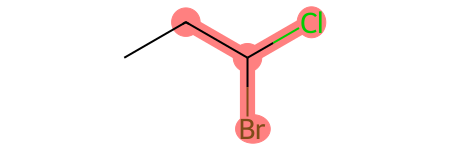

In [11]:
match = mol.GetSubstructMatch(pattern)
print("Matched indices:", match)
display(mol)

In [12]:
indices_matched = []
for bond in pattern.GetBonds():
    i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    bond = mol.GetBondBetweenAtoms(match[i], match[j])
    indices_matched.append(bond.GetIdx())
print("Matched bond indices:", indices_matched)

Matched bond indices: [2, 1, 0]


In [13]:
indices_all = list(range(mol.GetNumBonds()))
indices_rest = [i for i in indices_all if i not in indices_matched]
indices_new = indices_matched + indices_rest
print("Rest of bond indices:", indices_rest)
print("New bond index order:", indices_new)

Rest of bond indices: [3]
New bond index order: [2, 1, 0, 3]


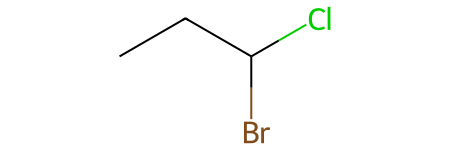

In [14]:
rw_mol = Chem.RWMol(mol)

bond_info = []
for bond in list(rw_mol.GetBonds()):
    bond_info.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()))
    rw_mol.RemoveBond(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

for i in indices_new:
    rw_mol.AddBond(*bond_info[i])
display(rw_mol)

CHI_UNSPECIFIED
CHI_TETRAHEDRAL_CW
CHI_UNSPECIFIED
CHI_UNSPECIFIED


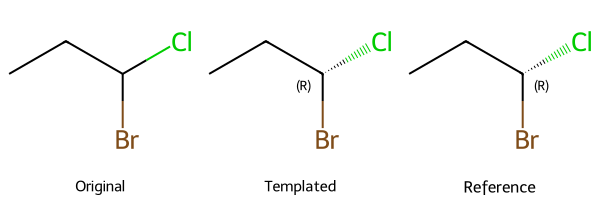

In [15]:
for i, atom in enumerate(pattern.GetAtoms()):
    chiral_tag = atom.GetChiralTag()
    print(chiral_tag)
    rw_mol.GetAtomWithIdx(match[i]).SetChiralTag(chiral_tag)
    
mol_new = rw_mol.GetMol()
Chem.SanitizeMol(mol_new)
Chem.AssignCIPLabels(mol_new)

Chem.Draw.MolsToGridImage([mol, mol_new, mol_ref], legends=["Original", "Templated", "Reference"], molsPerRow=3, useSVG=True)